In [1]:
%load_ext lab_black

In [2]:
import pandas as pd
from multiprocessing.dummy import Pool
import math

import torch

import numpy as np
from tqdm import tqdm
from pathlib import Path
from collections import defaultdict
import random
import matplotlib.pyplot as plt

from scipy.ndimage.filters import gaussian_filter

In [3]:
train_csv = pd.read_csv("data/train_features.csv")
train = train_csv.to_numpy()
train_csv

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [6]:
train.shape

(1875000, 8)

In [36]:
xs_train = np.stack(np.split(train[:, 2:].T, 3125, 1))
xs_train.shape

(3125, 6, 600)

In [28]:
test_csv = pd.read_csv("data/test_features.csv")
test = test_csv.to_numpy()
test_csv

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,3125,0,-0.628100,-0.160155,0.151487,49.665357,88.435961,13.597668
1,3125,1,-0.462548,0.012462,-0.053726,56.953059,96.185341,16.278458
2,3125,2,-0.363481,-0.091789,-0.130004,29.557396,93.836453,13.329043
3,3125,3,-0.351750,-0.239870,-0.193053,23.686172,88.608721,13.449771
4,3125,4,-0.312934,-0.123762,-0.318621,20.410071,85.327707,13.884912
...,...,...,...,...,...,...,...,...
469195,3906,595,0.104191,-0.784979,0.639513,-10.475346,14.095361,-190.358982
469196,3906,596,0.103297,-0.758954,0.615687,-25.360272,-8.523018,-180.393291
469197,3906,597,0.128294,-0.749389,0.586184,-27.917723,-23.186245,-162.624160
469198,3906,598,0.104130,-0.692731,0.573397,-27.847980,-30.407555,-138.761676


In [33]:
xs_test = np.stack(np.split(test[:, 2:].T, 782, 1))

In [34]:
xs_test.shape

(782, 6, 600)

In [62]:
xs = np.concatenate([xs_train, xs_test])

In [42]:
for i in range(2, 8):
    print(
        f"{i}: {train[:, i].mean():.4f}, {train[:, i].std():.4f}, {train[:, i].max():.4f}, {train[:, i].min():.4f}"
    )

2: -0.4490, 0.7173, 8.4268, -8.8384
3: -0.1618, 0.5872, 8.4846, -9.2997
4: 0.0557, 0.4725, 6.4327, -8.3164
5: -1.3080, 60.8323, 1870.2560, -1811.1267
6: -0.4338, 73.2983, 2111.6568, -1594.2556
7: 0.8864, 70.6334, 1255.8492, -1346.1430


In [41]:
for i in range(6):
    print(
        f"{i}: {xs[:, i].mean():.4f}, {xs[:, i].std():.4f}, {xs[:, i].max():.4f}, {xs[:, i].min():.4f}"
    )

0: -0.4492, 0.7178, 8.4268, -8.8384
1: -0.1672, 0.5844, 8.4846, -9.2997
2: 0.0540, 0.4727, 7.5170, -8.3164
3: -1.3200, 61.3287, 1870.2560, -1811.1267
4: -0.5244, 73.2311, 2111.6568, -1594.2556
5: 0.8139, 70.6200, 1255.8492, -1346.1430


train/test 비슷한 분포를 갖고 있음

채널별 분포 차이가 커서 normalization이 필요

standardization과 -1~1로 normalization을 두 번 거침

가속도 값이기 때문에 기준(offset)이 없음. 그냥 standardization을 각각의 아이템마다 해서 offset을 없애는건 정보 손실이 없음

크기는 같은 채널이라도 서로 재각각...  
offset을 없애도 그럴까?

In [63]:
xs = torch.tensor(xs, dtype=torch.float32)

In [66]:
xs.shape

torch.Size([3907, 6, 600])

In [67]:
for i in range(6):
    xs[:, i] = (xs[:, i] - xs[:, i].mean()) / xs[:, i].std()

In [68]:
for i in range(6):
    print(i, xs[:, i].mean(), xs[:, i].std(), xs[:, i].max(), xs[:, i].min())

0 tensor(-3.4160e-08) tensor(1.) tensor(12.3658) tensor(-11.6875)
1 tensor(-2.0413e-08) tensor(1.) tensor(14.8047) tensor(-15.6274)
2 tensor(-1.1664e-08) tensor(1.) tensor(15.7877) tensor(-17.7075)
3 tensor(-4.2700e-09) tensor(1.) tensor(30.5171) tensor(-29.5099)
4 tensor(-4.1398e-09) tensor(1.) tensor(28.8427) tensor(-21.7630)
5 tensor(4.7907e-09) tensor(1.) tensor(17.7717) tensor(-19.0733)


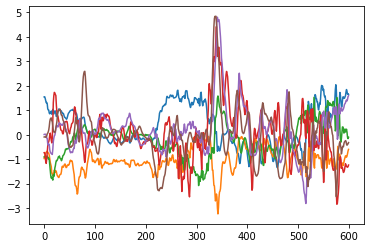

In [83]:
plt.plot(xs[11].transpose(0, 1))

In [85]:
xs[11, :, 0], xs[11, :, -1]

(tensor([ 1.5432, -0.9749, -0.9089, -0.7347,  0.0095, -0.0941]),
 tensor([ 1.6506, -0.6009, -0.1057, -1.2410,  1.5905, -0.3231]))

가속도 신호는 앞뒤가 정확하게 일치하지는 않음.

# 속도를 역산

In [86]:
x = xs[0]
x.shape

torch.Size([6, 600])

In [88]:
xs.shape

torch.Size([3907, 6, 600])

In [119]:
xsm = xs.clone()

In [126]:
xsmz = (xsm - xsm.mean(dim=2, keepdim=True)) / xsm.std(dim=2, keepdim=True)

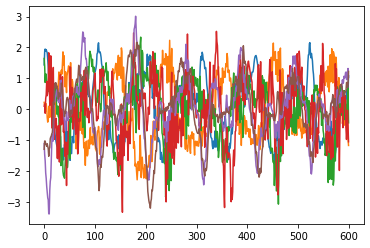

In [127]:
plt.plot(xsmz[0].transpose(0, 1))

In [128]:
xsmz[0, :, 0], xsmz[0, :, -1]

(tensor([ 1.4349,  0.2207,  1.6427,  0.0959, -1.1189, -1.3000]),
 tensor([ 1.0802, -1.1764, -0.4428, -1.0558,  1.0302,  1.2242]))

In [129]:
vs = [xsmz[:, :, 0] * 0.02]
for i in range(1, 600):
    vs.append(vs[i - 1] + xsmz[:, :, i] * 0.02)

In [130]:
vs = torch.stack(vs, dim=2)

In [131]:
vs.shape

torch.Size([3907, 6, 600])

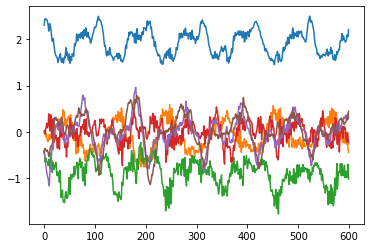

In [132]:
plt.plot(xs[0].transpose(0, 1))

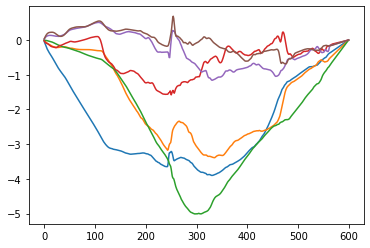

In [155]:
plt.plot(vs[14].transpose(0, 1))

In [135]:
vs[0, :, 0], vs[0, :, -1]

(tensor([ 0.0287,  0.0044,  0.0329,  0.0019, -0.0224, -0.0260]),
 tensor([-4.8429e-07, -3.5018e-07, -1.0021e-06,  3.7253e-08, -5.2154e-08,
          1.6764e-08]))

In [156]:
xs.shape, vs.shape

(torch.Size([3907, 6, 600]), torch.Size([3907, 6, 600]))

In [169]:
vsm = vs.clone()

In [170]:
vsmz = (vsm - vsm.mean(dim=2, keepdim=True)) / vsm.std(dim=2, keepdim=True)

In [171]:
ms = [vs[:, :, 0] * 0.02]
for i in range(1, 600):
    ms.append(ms[i - 1] + vsmz[:, :, i] * 0.02)

In [172]:
ms = torch.stack(ms, dim=2)

In [173]:
ms.shape

torch.Size([3907, 6, 600])

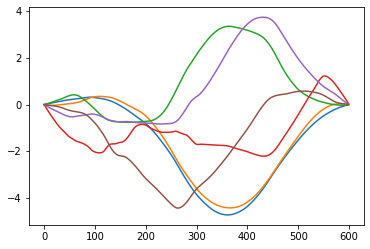

In [194]:
plt.plot(ms[1228].transpose(0, 1))

In [196]:
ts = torch.cat([xs, vs, ms], dim=1)

In [197]:
ts.shape

torch.Size([3907, 18, 600])

In [199]:
labels = pd.read_csv("data/train_labels.csv")
labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


In [203]:
labels = labels["label"].to_numpy()

In [204]:
len(labels)

3125

In [206]:
np.savez_compressed(
    "data/0206_org.npz",
    X_train=ts[: len(labels)].numpy(),
    Y_train=labels,
    X_test=ts[len(labels) :].numpy(),
)